# Bitbot

## Setup

### Jupyter

In [41]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Imports

In [42]:
%%capture test
import pandas as pd
from src.bitbot import BitBot
import sys
!{sys.executable} -m pip install ccxt mplfinance yfinance
import ccxt
import mplfinance as mpf
from matplotlib.pyplot import imshow
import yfinance
import pathlib
import os
from src.configuration.bitbot_files import use_config_dir
from src.configuration.bitbot_config import load_config_ini

### Load config files

In [43]:
curdir = pathlib.Path(os.path.abspath('')).resolve()
files = use_config_dir(curdir)
config = load_config_ini(files)
config.set('display', 'output', 'disk')

## Bitbot display output  

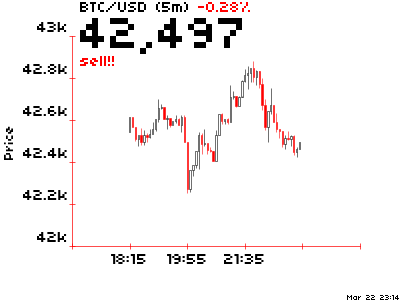

In [44]:
app = BitBot(config, files)
img  = app.display_chart()
img.show()

## Bitbot chart generation

In [45]:
# fetch configured candle history
from src.exchanges import crypto_exchanges
exchange = crypto_exchanges.Exchange(config)
chart_data = exchange.fetch_history()

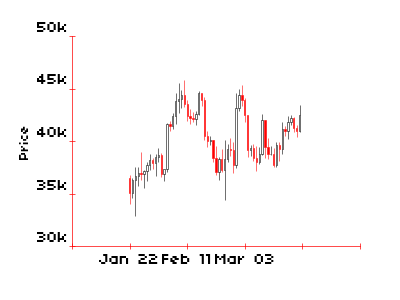

In [46]:
# plot chart and show image
from src.drawing.market_chart import MarketChart
from src.display.picker import picker as display_picker
from PIL import Image
import io

display = display_picker(config)
chart = MarketChart(config, display, files)

with io.BytesIO() as file_stream:
    chart.create_plot(chart_data).write_to_stream(file_stream)
    chart_image = Image.open(file_stream)
    chart_image.show()

## MPF plot

In [47]:
# load markets for selected exchange
exchange = getattr(ccxt, 'bitmex')()
mkts = exchange.loadMarkets()

In [187]:
# fetch candles
exchange_data = exchange.fetchOHLCV('BTC/USD', '5m', limit=40)
# convert candles to dataframe
df = pd.DataFrame(exchange_data)
df.columns = ["Date", "Open", "Low", "High", "Close", "Volume"]
df['Date'] = pd.to_datetime(df['Date'].astype('datetime64[ms]'))

#df.index = pd.DatetimeIndex(df["Date"].astype('datetime64[ms]'))
df.set_index('Date', inplace=True)
# df

### Try draw attractive graph

#### arse

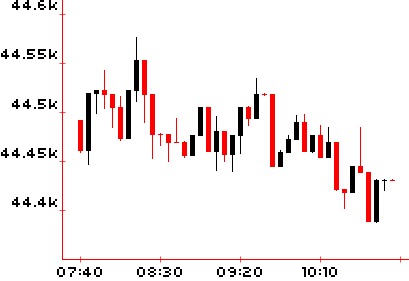

In [211]:
from matplotlib.ticker import EngFormatter
import numpy 

display_size = (400,300)

mc = mpf.make_marketcolors(
    alpha=1.0,
    up='black', down='red',
    edge={'up': 'black', 'down': 'red'},  # 'none',
    wick={'up': 'black', 'down': 'red'},
    volume={'up': 'black', 'down': 'red'}
)

s = mpf.make_mpf_style(
    marketcolors=mc,
    base_mpl_style=files.base_style,
    mavcolors=['#1f77b4', '#ff7f0e', '#2ca02c'],
)

candle_time_delta = df.index.values[1] - df.index.values[0]
if(candle_time_delta <= numpy.timedelta64(1,'h')):
    format = '%H:%M'
elif(candle_time_delta <= numpy.timedelta64(1,'D')): 
    format = '%b.%d'
else:
    format = '%b'


fig, ax = mpf.plot(
    df,
    scale_width_adjustment=dict(volume=0.9, candle=0.7, lines=0.05),
    update_width_config=dict(candle_linewidth=0.6),
    returnfig=True,
    type='candle',
    # mav=(10, 20),
    # volume=True,
    style=s,
    tight_layout=True,
    figsize=tuple(dim/100 for dim in display_size),
    xrotation=0,
    datetime_format=format,
)

#ax[0].xaxis.set_major_locator(mdates.AutoDateLocator(interval_multiples=True))
#ax[0].xaxis.set_major_formatter(date_formatter)
#ax[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[0].xaxis.major.locator))
#ax[0].xaxis.set_major_formatter(MyFormatter(df.index))
for a in ax: 
    a.yaxis.set_major_formatter(EngFormatter(sep=''))
    a.autoscale(enable=True, axis="x", tight=True)
    a.autoscale(enable=True, axis="y", tight=True)
    a.margins(0.05, 0.2)
    _ = a.set_ylabel("")
    _ = a.set_xlabel("")
fig